In [1]:
import os
import platform
import numpy as np
import pandas as pd
from multiprocess import Pool, cpu_count
import plotly.express as px

from mail_helpers import ingest_emails


pd.options.mode.copy_on_write = True
# pd.read_csv(fname, engine='pyarrow', dtype_backend='pyarrow')
# pd.Series([1, 2, 3, 4], dtype='int64[pyarrow]')
# pd.Series(['foo', 'bar', 'foobar'], dtype='string[pyarrow]')
# pd.read_csv(my_file, use_nullable_dtypes=True)


Enron Email Dataset

https://www.cs.cmu.edu/~./enron/

In [2]:
# Message files end with a dot. This is not supported on Windows.
# Workaround for Windows:
# Add the prefix "\\?\" to the path to force the OS to read the files.
# normpath() is used everywhere to make sure things remain portable.
cwd = os.getcwd()
if platform.system() == "Windows":
    cwd = "\\\\?\\" + cwd
basedir = cwd + os.path.normpath("/maildir")
top_level_dirs = os.listdir(basedir)

if __name__ == "__main__":
    cpus = cpu_count()
    arglist = list(zip([basedir] * len(top_level_dirs), top_level_dirs))
    with Pool(processes=cpus) as mp_pool:
        mp_results = mp_pool.map_async(ingest_emails, arglist)
        mp_results.wait()
    all_emails = pd.concat([r for r in mp_results.get()], ignore_index=True)
    del mp_results
    del mp_pool


In [3]:
# convert float seconds to datetime
all_emails["Date"] = pd.to_datetime(all_emails["Date"], unit="s")


In [4]:
all_emails.dtypes


Top_Level_Folder            object
Mail_Folder                 object
Message_File                 int64
From                        object
To                          object
Cc                          object
Bcc                         object
Date                datetime64[ns]
Subject                     object
Body                        object
Body_Message                object
Body_Quoted                 object
dtype: object

In [5]:
all_emails


,Top_Level_Folder,Mail_Folder,Message_File,From,To,Cc,Bcc,Date,Subject,Body,Body_Message,Body_Quoted
0,allen-p,all_documents,1,['1.11913372.-2@multexinvestornetwork.com'],['pallen@enron.com'],[],[],2000-12-14 02:41:00,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...,In today's Daily Update you'll find free repor...,
1,allen-p,all_documents,10,['messenger@ecm.bloomberg.com'],[],[],[],2000-12-13 16:35:00,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,Here is today's copy of Bloomberg Power Lines....,
2,allen-p,all_documents,100,['phillip.allen@enron.com'],['keith.holst@enron.com'],[],[],2000-10-09 14:16:00,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,---------------------- Forwarded by Phillip K ...,
3,allen-p,all_documents,101,['phillip.allen@enron.com'],['keith.holst@enron.com'],[],[],2000-10-09 14:00:00,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,---------------------- Forwarded by Phillip K ...,
4,allen-p,all_documents,102,['phillip.allen@enron.com'],['david.delainey@enron.com'],[],[],2000-10-05 13:26:00,,"Dave, \n\n Here are the names of the west desk...","Dave, \n\n Here are the names of the west desk...",
...,...,...,...,...,...,...,...,...,...,...,...,...
517396,zufferli-j,sent_items,95,['john.zufferli@enron.com'],['kori.loibl@enron.com'],[],[],2001-11-28 21:30:11,Trade with John Lavorato,This is a trade with OIL-SPEC-HEDGE-NG (John L...,This is a trade with OIL-SPEC-HEDGE-NG (John L...,
517397,zufferli-j,sent_items,96,['john.zufferli@enron.com'],['john.lavorato@enron.com'],[],[],2001-11-28 20:47:48,Gas Hedges,Some of my position is with the Alberta Term b...,Some of my position is with the Alberta Term b...,
517398,zufferli-j,sent_items,97,['john.zufferli@enron.com'],['dawn.doucet@enron.com'],[],[],2001-11-28 15:20:00,RE: CONFIDENTIAL,2\n\n -----Original Message-----\nFrom: \tDouc...,2\n\n -----Original Message-----,"From: \tDoucet, Dawn \nSent:\tWednesday, Nove..."
517399,zufferli-j,sent_items,98,['john.zufferli@enron.com'],['jeanie.slone@enron.com'],[],[],2001-11-27 19:52:45,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,


In [6]:
# remove datetime outliers
# only keep Oct 1998 - Jul 2002
all_emails = all_emails.query("Date >= '1998-10-01' and Date <= '2002-07-31'")


In [7]:
# check for empty messages
all_emails[all_emails["Body_Message"].str.len() == 0].shape[0]


0

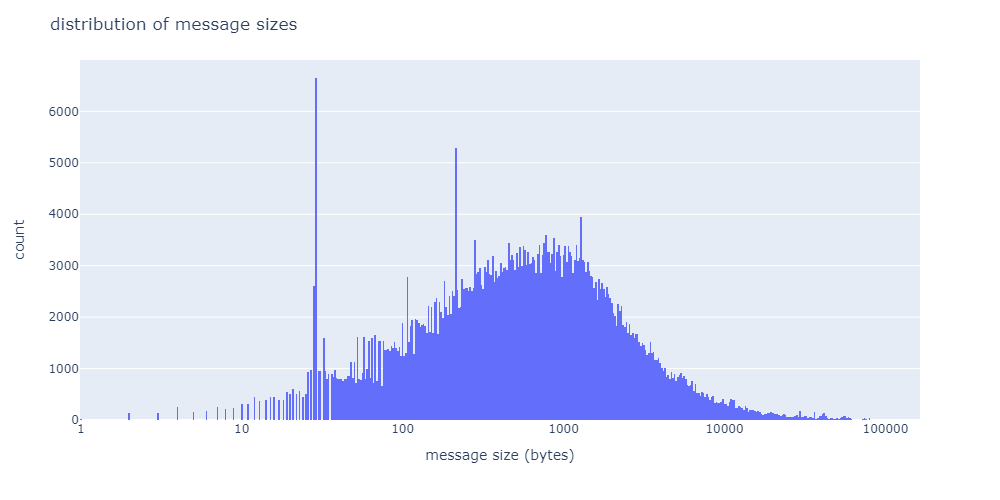

In [8]:
# px.histogram(..., log_x=True) doesn't work, this is a workaround
bm_len_max_exp = int(np.log10(all_emails["Body_Message"].str.len().max())) + 1
bm_len_tick_list = list(range(bm_len_max_exp))
bm_len_tick_text = np.power(10, bm_len_tick_list)

# datetime distribution
px.histogram(
    data_frame=np.log10(all_emails["Body_Message"].str.len().to_numpy())
).update_layout(
    title_text="distribution of message sizes",
    width=1000,
    height=500,
    showlegend=False,
    xaxis_title="message size (bytes)",
    xaxis_tickvals=bm_len_tick_list,
    xaxis_ticktext=bm_len_tick_text,
    yaxis_title="count",
).show(
    "png"
)


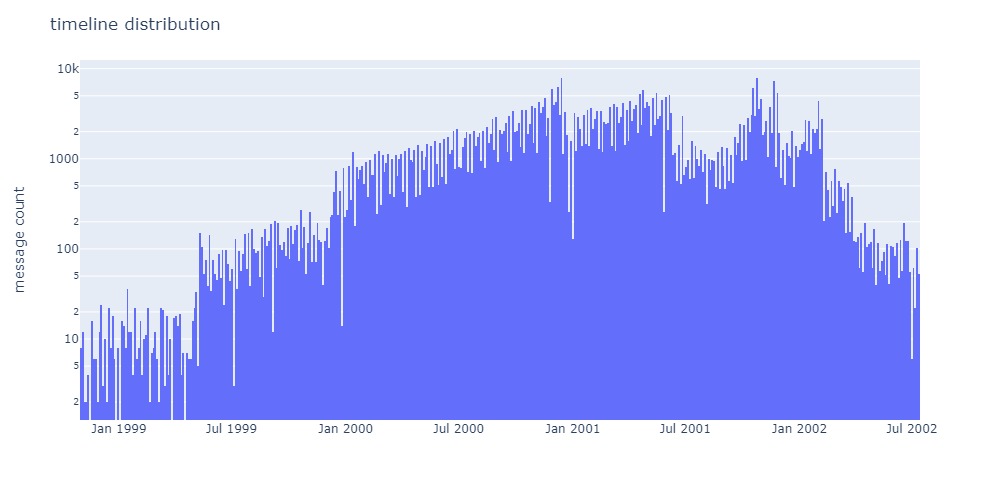

In [9]:
# datetime distribution
px.histogram(data_frame=all_emails["Date"], log_y=True).update_layout(
    title_text="timeline distribution",
    width=1000,
    height=500,
    showlegend=False,
    xaxis_title=None,
    yaxis_title="message count",
).show("png")


In [10]:
# check for null values
all_emails.isnull().sum()


Top_Level_Folder    0
Mail_Folder         0
Message_File        0
From                0
To                  0
Cc                  0
Bcc                 0
Date                0
Subject             0
Body                0
Body_Message        0
Body_Quoted         0
dtype: int64

In [11]:
# message count
all_emails.shape[0]


516345

In [12]:
# save to file
if os.path.exists("all_emails.csv"):
    os.remove("all_emails.csv")
all_emails.to_csv("all_emails.csv", index=False)
